<a href="https://colab.research.google.com/github/mjalalimanesh/applied-data-analytics-with-python/blob/main/notebooks/retention_cohort.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme()

In [92]:
url = 'https://raw.githubusercontent.com/mjalalimanesh/applied-data-analytics-with-python/main/database/Superstore.csv?token=GHSAT0AAAAAABZ3QDJUJBLE5GERFVE5TCIKY2G4EQQ'
df = pd.read_csv(url, encoding='unicode_escape')

In [53]:
def tweak_superstore(df):
  return (df
          .rename(columns=lambda c: c.lower().replace(' ', '_').replace('-', '_'))
          .rename(columns={'country/region': 'country'})
          .drop(labels=['ship_date', 'ship_mode'], axis='columns')
          .assign(order_date= lambda _df: pd.to_datetime(_df.order_date))
          .astype({k: 'category' for k in ['segment', 'category', 'sub_category', 'country', 'region', 'state']})
  )

orders = tweak_superstore(df)
orders.head(3)

,row_id,order_id,order_date,customer_id,customer_name,segment,country,city,state,postal_code,region,product_id,category,sub_category,product_name,sales,quantity,discount,profit
0,1,CA-2018-152156,2018-11-08,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136
1,2,CA-2018-152156,2018-11-08,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.0,219.5820
2,3,CA-2018-138688,2018-06-12,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.62,2,0.0,6.8714


In [91]:
numbers_cohort = (orders
                  .assign(first_purchase = lambda _df: _df.groupby('customer_id')['order_date'].transform('min').dt.to_period('M').dt.to_timestamp())
                  .groupby(by=['first_purchase', pd.Grouper(key="order_date", freq="MS")])
                  ['customer_id']
                  .nunique()
                  .reset_index()
                  .assign(diff= lambda df_: np.round((df_.order_date - df_.first_purchase)/np.timedelta64(1, 'M')).astype('int'))
                  .pivot(values='customer_id', index='first_purchase', columns='diff')
                  .fillna(0)
                  .iloc[0:12, 0:13]
)

# Beautify and Visualize
(numbers_cohort
 .reset_index()
 .style
 .format({
     'first_purchase': '{:%Y/%m}',
     **{col: '{:.0f}' for col in range(13)}
 })
 .background_gradient(axis=None, cmap='Blues')
  .set_caption('Monthly Retention Cohort (Number of Customers)')
  .set_properties(**{'text-align': 'center', 'width': '40px'})
 .hide_index()
)


first_purchase,0,1,2,3,4,5,6,7,8,9,10,11,12
2016/01,32,3,0,2,2,0,2,4,5,3,7,5,3
2016/02,24,4,2,1,0,2,2,3,3,4,4,1,0
2016/03,65,4,2,8,7,0,7,5,8,6,1,2,6
2016/04,56,6,2,4,3,8,6,9,8,1,4,5,8
2016/05,56,5,5,4,10,2,12,10,4,3,4,7,2
2016/06,48,1,2,4,2,9,8,1,4,6,5,5,3
2016/07,44,6,5,0,5,8,2,0,8,2,7,7,5
2016/08,49,8,3,11,5,3,4,2,4,3,5,6,2
2016/09,68,9,9,11,1,2,9,10,9,2,6,8,12
2016/10,42,3,5,1,3,4,5,4,3,4,4,7,4


In [67]:
percent_cohort = (numbers_cohort
                  .divide(numbers_cohort.iloc[:, 0], axis='index')
                  .mul(100)
                  .round(1))

# Beautify and Visualize
(percent_cohort
 .reset_index()
 .style
 .format({
     'first_purchase': '{:%Y/%m}',
     **{col: '{:.0f}%' for col in range(13)}
 })
 .background_gradient(axis=None, cmap='Blues', vmax=40)
  .set_caption('Monthly Retention Cohort (Percent)')
  .set_properties(**{'text-align': 'center', 'width': '50px'})
 .hide_index()
)

first_purchase,0,1,2,3,4,5,6,7,8,9,10,11,12
2016/01,100%,9%,0%,6%,6%,0%,6%,12%,16%,9%,22%,16%,9%
2016/02,100%,17%,8%,4%,0%,8%,8%,12%,12%,17%,17%,4%,0%
2016/03,100%,6%,3%,12%,11%,0%,11%,8%,12%,9%,2%,3%,9%
2016/04,100%,11%,4%,7%,5%,14%,11%,16%,14%,2%,7%,9%,14%
2016/05,100%,9%,9%,7%,18%,4%,21%,18%,7%,5%,7%,12%,4%
2016/06,100%,2%,4%,8%,4%,19%,17%,2%,8%,12%,10%,10%,6%
2016/07,100%,14%,11%,0%,11%,18%,4%,0%,18%,4%,16%,16%,11%
2016/08,100%,16%,6%,22%,10%,6%,8%,4%,8%,6%,10%,12%,4%
2016/09,100%,13%,13%,16%,2%,3%,13%,15%,13%,3%,9%,12%,18%
2016/10,100%,7%,12%,2%,7%,10%,12%,10%,7%,10%,10%,17%,10%


Text(0.5, 1.0, '2016 Monthly Retention Cohorts')

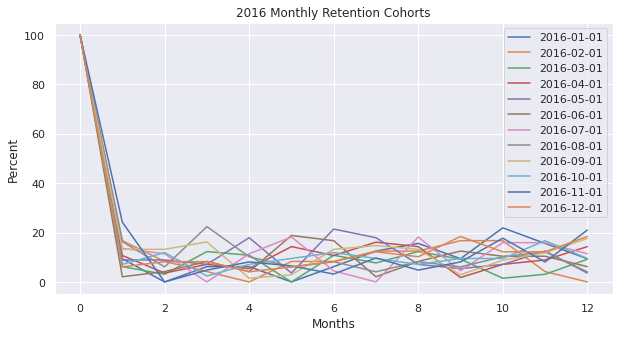

In [89]:
fig, ax = plt.subplots(figsize=(10,5))

(percent_cohort
 .rename(mapper=lambda ind: ind.strftime('%Y-%m-%d'), axis='index')
 .T
 .plot(ax=ax)
 .legend(bbox_to_anchor=(1,1))
)

ax.set_ylabel('Percent')
ax.set_xlabel('Months')
ax.set_title('2016 Monthly Retention Cohorts')

Text(0.5, 1.0, '2016 Average Retention Cohort')

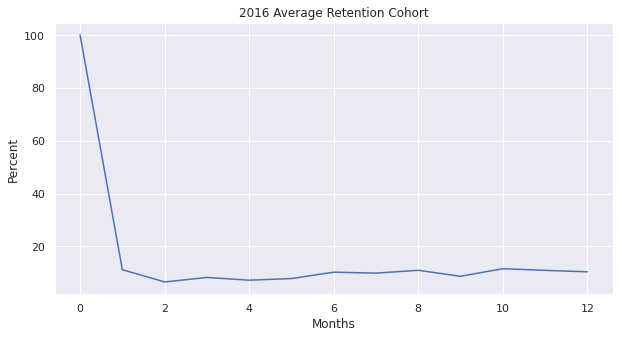

In [90]:
fig, ax = plt.subplots(figsize=(10,5))

(percent_cohort
 .rename(mapper=lambda ind: ind.strftime('%Y-%m-%d'), axis='index')
 .T
 .mean(axis='columns')
 .plot(ax=ax)
)

ax.set_ylabel('Percent')
ax.set_xlabel('Months')
ax.set_title('2016 Average Retention Cohort')